In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define various functions to generate and visualize time series data
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
# Time series data parameters
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)  
baseline = 20
amplitude = 30
slope = 0.12
noise_level = 5

In [4]:
# Create the time series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Add noise to the data
series += noise(time, noise_level, seed=42)

In [5]:
# Split data into training and validation periods
split_time = 880
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

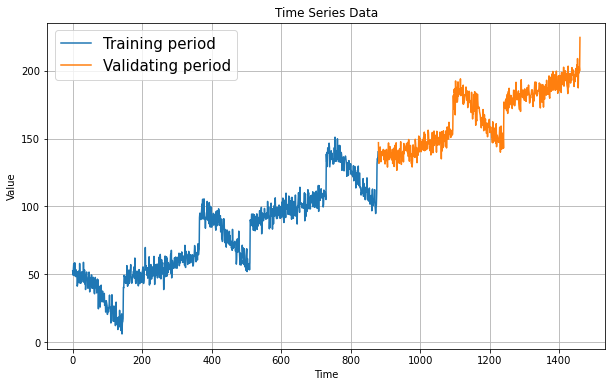

In [6]:
# Visualize time series data
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)
plt.title("Time Series Data")
plt.legend(["Training period", "Validating period"],prop={'size': 15})
plt.show()

In [7]:
# Create dataset for training with training windows
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
# Clear backend session for repeated trials
tf.keras.backend.clear_session()

In [9]:
# window_size = 60
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
# Train DNN with a few hidden layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=4e-7, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=50, verbose=1)

Epoch 1/50
26/26 [==============================] - 1s 2ms/step - loss: 3601.5942
Epoch 2/50
26/26 [==============================] - 0s 1ms/step - loss: 247.8481
Epoch 3/50
26/26 [==============================] - 0s 2ms/step - loss: 164.5240
Epoch 4/50
26/26 [==============================] - 0s 1ms/step - loss: 126.7384
Epoch 5/50
26/26 [==============================] - 0s 1ms/step - loss: 118.0083
Epoch 6/50
26/26 [==============================] - 0s 2ms/step - loss: 113.5530
Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 108.8142
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 104.6711
Epoch 9/50
26/26 [==============================] - 0s 2ms/step - loss: 101.3018
Epoch 10/50
26/26 [==============================] - 0s 2ms/step - loss: 97.6107
Epoch 11/50
26/26 [==============================] - 0s 2ms/step - loss: 94.6282
Epoch 12/50
26/26 [==============================] - 0s 2ms/step - loss: 94.0226
Epoch 13/50
26/26 [========

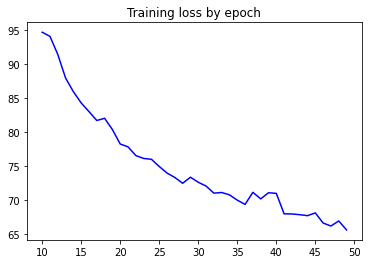

In [11]:
# Plot loss optimization for all but the first 10 epochs
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]

plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.title("Training loss by epoch")
plt.show()

In [12]:
# Forecast values for the validation period
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

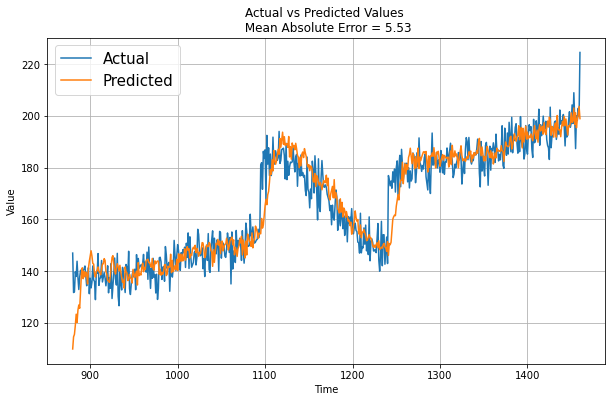

In [13]:
# Visualize actual vs predicted values and print performance metrics
mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.title("Actual vs Predicted Values \n Mean Absolute Error = {:0.2f}".format(mae))
plt.legend(["Actual","Predicted"],prop={'size': 15})
plt.show()